# NFT Authenticity and Prediction using Sentiment Analysis and Deep Learning

## Imports

In [75]:
import json
import asyncio
import tqdm
import tqdm.asyncio
import nest_asyncio
from sklearn.naive_bayes import GaussianNB
from sklearn import svm, metrics, preprocessing
from sklearn.model_selection import cross_val_score, train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import pandas as pd
nest_asyncio.apply()
import os
from dotenv import load_dotenv
load_dotenv()
from pprint import pprint
from datetime import datetime
from dateutil.relativedelta import relativedelta
from aiohttp import ClientSession, TCPConnector
from matplotlib import pyplot
import tweepy

## Data Collection

Get Project List Data

In [11]:
df = pd.read_csv("collections.csv")
sample_slugs = df['slug'].values
slug_date = {}
slug_price = {}

### OpenSea Metrics from Collection Slugs

Asynchronous Data Collection

In [12]:
async def fetchData(url,session):
    async with session.get(url) as response:
        try:
            response = await response.read()
            assert 'detail' not in json.loads(response.decode('UTF-8'))
            return response
        except:
            await asyncio.sleep(5)
            return await fetchData(url,session)

async def transactionScrape():
    tasks = []
    responses = []
    connector = TCPConnector(limit_per_host=1)
    url = "https://api.opensea.io/api/v1/events?collection_slug={slug}&only_opensea=false&event_type=successful&limit=300&occurred_after={start}&occurred_before={end}"
    headers={"Accept": "application/json", "X-API-KEY": os.getenv('OPENSEA_API_KEY')}
    async with ClientSession(connector=connector, headers=headers) as session:
        for i in range(len(sample_slugs)):
            start_date = datetime.fromisoformat(slug_date[sample_slugs[i]].split('T')[0]) - relativedelta(days=1)
            for j in range(14):
                start_date = start_date + relativedelta(days=1)
                end_date = start_date + relativedelta(days=1) 
                task = asyncio.ensure_future(fetchData(url.format(slug=sample_slugs[i],start=start_date.timestamp(), end=end_date.timestamp()),session))
                tasks.append(task)
        for f in tqdm.tqdm(asyncio.as_completed(tasks), total=len(tasks)):
            responses.append(await f)
    for response in responses:
        response = json.loads(response.decode('utf8'))
        try:
            collection_slug = response['asset_events'][0]['collection_slug'] 
            for event in response['asset_events']:
                slug_price[collection_slug]['total_volume'] += float(event['total_price'])/1000000000000000000
                slug_price[collection_slug]['num_transactions'] += 1
        except:
            pass

async def collectionScrape():
    tasks = []
    responses = []
    connector = TCPConnector()
    url = "https://api.opensea.io/api/v1/collection/{}"
    async with ClientSession(connector=connector) as session:
        for i in range(len(sample_slugs)):
            task = asyncio.ensure_future(fetchData(url.format(sample_slugs[i]),session))
            tasks.append(task)
        for f in tqdm.tqdm(asyncio.as_completed(tasks), total=len(tasks)):
            responses.append(await f)
    for response in responses:
        response = json.loads(response.decode('utf8'))
        name = response['collection']['name']
        floor = response['collection']['stats']['floor_price']
        volume = response['collection']['stats']['total_volume']
        date_created = response['collection']['created_date']
        slug_date[response['collection']['slug']] = date_created
        slug_price[response['collection']['slug']] = {'total_volume' : 0, 'num_transactions': 0 }
        print(f'{name}: Floor: {floor}ETH --- Total Volume: {volume}ETH --- Created {date_created}')


Run Collection Script

In [13]:
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(collectionScrape())
loop.run_until_complete(future)

100%|██████████| 7/7 [00:00<00:00, 34.15it/s]

Cool Cats NFT: Floor: 7.95ETH --- Total Volume: 58832.68086868852ETH --- Created 2021-06-27T09:03:35.403074
Evolved Apes Inc: Floor: 0.0025ETH --- Total Volume: 1155.893264119258ETH --- Created 2021-09-23T12:30:03.410309
Neo Tokyo Identities: Floor: 16.45ETH --- Total Volume: 11202.127364958142ETH --- Created 2021-10-04T15:14:32.376341
Bored Ape Yacht Club: Floor: 51.98ETH --- Total Volume: 248435.61510895318ETH --- Created 2021-04-22T23:14:03.967121
VeeFriends: Floor: 7.948ETH --- Total Volume: 32010.294588127756ETH --- Created 2021-05-11T18:22:19.398578
CryptoPunks: Floor: NoneETH --- Total Volume: 733080.3212493034ETH --- Created 2019-04-26T22:13:09.691572
Oracle (official): Floor: 0.0ETH --- Total Volume: 27.59211999999997ETH --- Created 2021-09-22T10:53:26.948567


Run Transaction Collections

In [14]:
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(transactionScrape())
loop.run_until_complete(future)
pprint(slug_price)

100%|██████████| 98/98 [05:17<00:00,  3.24s/it]


{'boredapeyachtclub': {'num_transactions': 1493,
                       'total_volume': 1036.042150458877},
 'cool-cats-nft': {'num_transactions': 3000, 'total_volume': 1348.559469115312},
 'cryptopunks': {'num_transactions': 112, 'total_volume': 50.751900000000006},
 'evolved-apes-inc': {'num_transactions': 2968,
                      'total_volume': 359.1697327089688},
 'neo-tokyo-identities': {'num_transactions': 541,
                          'total_volume': 5044.5502018807865},
 'oraclenft': {'num_transactions': 465, 'total_volume': 20.559649999999987},
 'veefriends': {'num_transactions': 86, 'total_volume': 204.1384013352507}}


Feature Extraction and Writing to Features File

In [8]:
df['volume'] = df['slug'].apply(lambda x: slug_price[x]['total_volume'])
df['transaction_count'] = df['slug'].apply(lambda x: slug_price[x]['num_transactions'])
df['average_sale'] = df['slug'].apply(lambda x: slug_price[x]['total_volume'] / slug_price[x]['num_transactions'])
df.to_csv('features.csv') 

{'cool-cats-nft': {'num_transactions': 900, 'total_volume': 60.342537256013955},
 'cryptopunks': {'num_transactions': 3, 'total_volume': 2.7},
 'evolved-apes-inc': {'num_transactions': 2028,
                      'total_volume': 320.1946983101896},
 'neo-tokyo-identities': {'num_transactions': 463,
                          'total_volume': 4264.695525091693},
 'veefriends': {'num_transactions': 10, 'total_volume': 14.500000000024919}}


### Twitter Historical Tweet Collection

Get Authorization Credentials

In [19]:
consumer_key = os.getenv('CONSUMER_KEY')
consumer_secret = os.getenv('CONSUMER_SECRET')
access_token = os.getenv('ACCESS_TOKEN')
access_token_secret = os.getenv('ACCESS_TOKEN_SECRET')

Configure Tweepy

In [20]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

Read in the Projects List

In [22]:
collections = pd.read_csv("collections.csv")["name"]
print(collections)

0       Bored Ape Yacht Club
1           Evolved Apes NFT
2                 Oracle NFT
3       Neo Tokyo Identities
4              Cool Cats NFT
5             Hype Hippo NFT
6             Veefriends NFT
7            The Sandbox NFT
8                 Apymon NFT
9             CyberKongz NFT
10               Meebits NFT
11        World of Women NFT
12     Mutant Human Club NFT
13        The Doge Pound NFT
14        Creature World NFT
15         Angry Anglers NFT
16                CloneX NFT
17               Doodles NFT
18      Panda Golf Squad NFT
19        Pepsi Mic Drop NFT
20         Miss Universe NFT
21    CryptoBull Society NFT
22      Chromie Squiggle NFT
23    Farmer Apes (FAYC) NFT
24          Jadu Jetpack NFT
25            Lazy Lions NFT
26          CryptoVoxels NFT
27           Doge Battle NFT
Name: name, dtype: object


Tweet Collection Script

In [23]:
def get_tweets(proj):
    filename = "./data/" + "_".join(proj.split(" ")) + ".csv"
    print("Collecting tweets for:", proj)
    print("Writing results to", filename)

    resp = api.search_full_archive("prod", proj)

    tweets = []
    timestamps = []

    for status in resp:
        tweets.append(status.text)
        timestamps.append(status.created_at)

    df = pd.DataFrame({
            "tweets": pd.Series(tweets),
            "timestamps": pd.Series(timestamps)
            })

    df.to_csv(filename)

Run Tweet Collection Script

In [25]:
for proj in collections:
    get_tweets(proj)

Writing results to ./data/Bored_Ape_Yacht_Club.csv
Writing results to ./data/Evolved_Apes_NFT.csv
Writing results to ./data/Oracle_NFT.csv
Writing results to ./data/Neo_Tokyo_Identities.csv
Writing results to ./data/Cool_Cats_NFT.csv
Writing results to ./data/Hype_Hippo_NFT.csv
Writing results to ./data/Veefriends_NFT.csv
Writing results to ./data/The_Sandbox_NFT.csv
Writing results to ./data/Apymon_NFT.csv
Writing results to ./data/CyberKongz_NFT.csv
Writing results to ./data/Meebits_NFT.csv
Writing results to ./data/World_of_Women_NFT.csv
Writing results to ./data/Mutant_Human_Club_NFT.csv
Writing results to ./data/The_Doge_Pound_NFT.csv
Writing results to ./data/Creature_World_NFT.csv
Writing results to ./data/Angry_Anglers_NFT.csv
Writing results to ./data/CloneX_NFT.csv
Writing results to ./data/Doodles_NFT.csv
Writing results to ./data/Panda_Golf_Squad_NFT.csv
Writing results to ./data/Pepsi_Mic_Drop_NFT.csv
Writing results to ./data/Miss_Universe_NFT.csv
Writing results to ./dat

## Use sentiment analysis to encode tweets

In [29]:
# FUNCTION TO PREPROCESS DATA

In [46]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np

In [57]:
def get_sentiment(tweets):
    '''
    Uses a VADER model to return the avg sentiment for a collection of tweets
    '''
    analyzer = SentimentIntensityAnalyzer()
    
    all_scores = [0, 0, 0]
    for tweet in tweets:
        score = analyzer.polarity_scores(tweet)
        
        all_scores.append(np.array([score['neg'], score['neu'], score['pos']]))
    
    return np.array(all_scores).mean(axis=0)

In [130]:
import time
import calendar

def get_volume_metric(timestamps):
    '''
    Function to compute the standard deviation of a series of timestamps
    this is meant to act as a metric for volume
    in practice this is an imperfect metric because it is heavily reliant upon twitter's api. 
    we were not able to get a premium license so our data was limited
    '''
    distances = []
    for t in timestamps:
        # get the number of seconds since the epoch
        distances.append(calendar.timegm(time.strptime(t, "%Y-%m-%d %H:%M:%S+00:00")))
    return pd.Series(distances).std()

### Add sentiment encodings to feature dataframe

In [167]:
features = pd.read_csv("features.csv")

negative_scores = []
neutral_scores = []
positive_scores = []
volume = []

for proj in features["name"]:
    filename = "./data/" + "_".join(proj.split(" ")) + ".csv"
    
    tweet_data = pd.read_csv(filename)
    
    print("Analyzing tweets for", proj)
    scores = get_sentiment(tweet_data["tweets"])
    timestamp_deviation = get_volume_metric(tweet_data["timestamps"])
    
    try:
        negative_scores.append(scores[0])
        neutral_scores.append(scores[1])
        positive_scores.append(scores[2])
    except Exception:
        negative_scores.append(0)
        neutral_scores.append(0)
        positive_scores.append(0)
        
    if timestamp_deviation:
        volume.append(timestamp_deviation)
    else:
        volume.append(0)
        
    
features["negative_score"] = pd.Series(negative_scores)
features["neutral_score"] = pd.Series(neutral_scores)
features["positive_score"] = pd.Series(positive_scores)
features["tweet_volume"] = pd.Series(volume)

features.to_csv("features.csv")

Analyzing tweets for Bored Ape Yacht Club
Analyzing tweets for Evolved Apes NFT
Analyzing tweets for Oracle NFT
Analyzing tweets for Neo Tokyo Identities


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Analyzing tweets for Cool Cats NFT
Analyzing tweets for Hype Hippo NFT
Analyzing tweets for Veefriends NFT
Analyzing tweets for The Sandbox NFT
Analyzing tweets for Apymon NFT
Analyzing tweets for CyberKongz NFT
Analyzing tweets for Meebits NFT
Analyzing tweets for World of Women NFT
Analyzing tweets for Mutant Human Club NFT
Analyzing tweets for The Doge Pound NFT
Analyzing tweets for Creature World NFT
Analyzing tweets for Angry Anglers NFT
Analyzing tweets for CloneX NFT
Analyzing tweets for Doodles NFT
Analyzing tweets for Panda Golf Squad NFT
Analyzing tweets for Pepsi Mic Drop NFT
Analyzing tweets for Miss Universe NFT
Analyzing tweets for CryptoBull Society NFT
Analyzing tweets for Chromie Squiggle NFT
Analyzing tweets for Farmer Apes (FAYC) NFT
Analyzing tweets for Jadu Jetpack NFT
Analyzing tweets for Lazy Lions NFT
Analyzing tweets for CryptoVoxels NFT
Analyzing tweets for Doge Battle NFT


In [172]:
features.head()

,name,slug,label,volume,transaction_count,average_sale,negative_score,neutral_score,positive_score,tweet_volume
0,Bored Ape Yacht Club,boredapeyachtclub,0,1036.042150,1493,0.693933,0.063476,0.822583,0.084806,2847.771264
1,Evolved Apes NFT,evolved-apes-inc,1,359.169733,2968,0.121014,0.061631,0.831971,0.077282,522296.884735
2,Oracle NFT,oraclenft,1,20.559650,465,0.044214,0.000000,0.759282,0.211592,852.930276
3,Neo Tokyo Identities,neo-tokyo-identities,0,5044.550202,541,9.324492,0.006330,0.834175,0.130369,77811.283279
4,Cool Cats NFT,cool-cats-nft,0,1348.559469,3000,0.449520,0.032728,0.832126,0.106019,12129.480684


## Classification Models

### Gaussian Naive Bayes

In [164]:
def predictNB(x_train, x_test, y_train, y_test):
    gnb = GaussianNB()
    y_pred = gnb.fit(x_train, y_train).predict(x_test)
    return metrics.accuracy_score(y_test, y_pred)

### Support Vector Machine (SVM)

In [165]:
def predictSVM(x_train, x_test, y_train, y_test):
    model = svm.SVC()
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    return metrics.accuracy_score(y_test, y_pred)

### Multilayer Perceptron (MLP)

In [166]:
def predictMLP(x_train, x_test, y_train, y_test):
    n_features = x_train.shape[1]
    model = Sequential()
    model.add(Dense(20, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=500, batch_size=8, verbose=0)
    pyplot.title('Learning Curve')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Binary Cross Entropy')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.legend()
    pyplot.show()   
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    return acc


## Data Preprocessing

We will create different training sets using text features only, price features only, and a combination of price and text features.

### Extract Features and Labels

In [181]:
dataset = pd.read_csv("features.csv").fillna(0)

x_data_price = dataset[['transaction_count', 'volume', 'average_sale']]
x_data_text = dataset[['negative_score','neutral_score','positive_score','tweet_volume']]
x_data_combined = dataset[['transaction_count', 'volume', 'average_sale','negative_score','neutral_score','positive_score','tweet_volume']]

y_data = dataset['label']

### Split Data into Testing and Training

In [182]:
x_train_price, x_test_price, y_train_price, y_test_price = train_test_split(x_data_price, y_data ,test_size = 0.2)

x_train_text, x_test_text, y_train_text, y_test_text = train_test_split(x_data_text, y_data ,test_size = 0.2)

x_train_combined, x_test_combined, y_train_combined, y_test_combined = train_test_split(x_data_combined, y_data ,test_size = 0.2)

### Standardize The Features

In [183]:
scaler = preprocessing.StandardScaler().fit(x_train_price)
x_train_scaled_price = scaler.transform(x_train_price)

scaler = preprocessing.StandardScaler().fit(x_test_price)
x_test_scaled_price = scaler.transform(x_test_price)

scaler = preprocessing.StandardScaler().fit(x_train_text)
x_train_scaled_text = scaler.transform(x_train_text)

scaler = preprocessing.StandardScaler().fit(x_test_text)
x_test_scaled_text = scaler.transform(x_test_text)

scaler = preprocessing.StandardScaler().fit(x_train_combined)
x_train_scaled_combined = scaler.transform(x_train_combined)

scaler = preprocessing.StandardScaler().fit(x_test_combined)
x_test_scaled_combined = scaler.transform(x_test_combined)

### Preview the data

In [176]:
x_train_combined.head()

,transaction_count,volume,average_sale,negative_score,neutral_score,positive_score,tweet_volume
11,4144,2824.486274,0.681585,0.044000,0.857505,0.069223,29294.837305
21,2466,4710.744583,1.910278,0.153155,0.737408,0.080311,68071.773454
20,157,13.913040,0.088618,0.000000,0.733000,0.237874,4326.050331
1,2968,359.169733,0.121014,0.061631,0.831971,0.077282,522296.884735
14,3391,4055.936939,1.196089,0.130010,0.771184,0.068864,7740.566757


In [177]:
x_train_text.describe()

,negative_score,neutral_score,positive_score,tweet_volume
count,22.000000,22.000000,22.000000,19.000000
mean,0.031399,0.716932,0.096461,145520.415603
std,0.042281,0.266101,0.068743,244597.518707
min,0.000000,0.000000,0.000000,289.566377
25%,0.001268,0.762257,0.059839,3831.970327
50%,0.012665,0.791107,0.078796,10778.428355
75%,0.054289,0.854374,0.144277,140472.917130
max,0.153155,0.902612,0.237874,747891.610700


## Running the Models

## Text Data Only

### Naive Bayes Prediction

In [184]:
predictNB(x_train_scaled_text, x_test_scaled_text, y_train_text, y_test_text)

0.6666666666666666

### SVM Model Prediction

In [185]:
predictSVM(x_train_scaled_text, x_test_scaled_text, y_train_text, y_test_text)

0.6666666666666666

### MLP Model Prediction

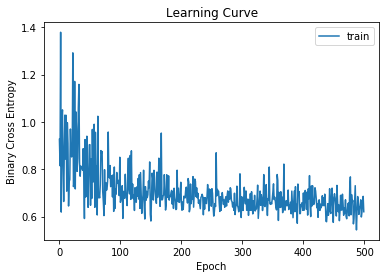

0.8333333134651184

In [186]:
predictMLP(x_train_scaled_text, x_test_scaled_text, y_train_text, y_test_text)

## Price Data Only

### Naive Bayes Prediction

In [187]:
predictNB(x_train_scaled_price, x_test_scaled_price, y_train_price, y_test_price)

0.5

### SVM Model Prediction

In [108]:
predictSVM(x_train_scaled_price, x_test_scaled_price, y_train_price, y_test_price)

0.8333333333333334

### MLP Model Prediction

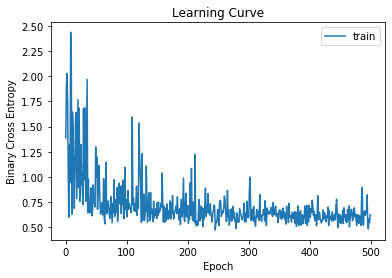

0.8333333134651184

In [109]:
predictMLP(x_train_scaled_price, x_test_scaled_price, y_train_price, y_test_price)

## Price and Text Data

### Naive Bayes Prediction

In [110]:
predictNB(x_train_scaled_combined, x_test_scaled_combined, y_train_combined, y_test_combined)

0.6666666666666666

### SVM Model Prediction

In [111]:
predictSVM(x_train_scaled_combined, x_test_scaled_combined, y_train_combined, y_test_combined)

0.8333333333333334

### MLP Model Prediction

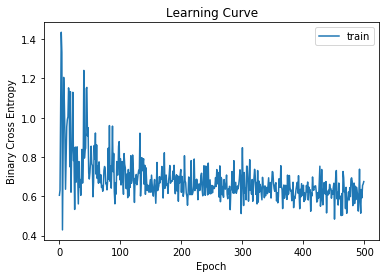

0.8333333134651184

In [112]:
predictMLP(x_train_scaled_combined, x_test_scaled_combined, y_train_combined, y_test_combined)